In [3]:
library("INLA")
library("dplyr")
library("tidyr")
library("ggplot2")
library("STRbook")
data("MOcarolinawren_long", package = "STRbook")

Loading required package: Matrix

Loading required package: sp

This is INLA_24.06.27 built 2024-06-27 02:36:04 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




In [2]:
# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)

Installing package into 'C:/Users/chatu/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

Warning message:
"dependencies 'HKprocess', 'Rgraphviz', 'graph' are not available"
also installing the dependencies 'locfit', 'ash', 'kernlab', 'mclust', 'multicool', 'pracma', 'hdrcde', 'ks', 'bitops', 'rainbow', 'RCurl', 'DEoptimR', 'pcaPP', 'fds', 'deSolve', 'robustbase', 'inline', 'rrcov', 'httr', 'selectr', 'fda', 'tis', 'jpeg', 'TeachingDemos', 'BMA', 'rvest', 'rbibutils', 'Ecfun', 'foreach', 'iterators', 'dfidx', 'Rdpack', 'mnormt', 'Ecdat', 'doParallel', 'evd', 'markdown', 'matrixStats', 'mlogit', 'pixmap', 'sn', 'INLAspacetime'




package 'locfit' successfully unpacked and MD5 sums checked
package 'ash' successfully unpacked and MD5 sums checked
package 'kernlab' successfully unpacked and MD5 sums checked
package 'mclust' successfully unpacked and MD5 sums checked
package 'multicool' successfully unpacked and MD5 sums checked
package 'pracma' successfully unpacked and MD5 sums checked
package 'hdrcde' successfully unpacked and MD5 sums checked
package 'ks' successfully unpacked and MD5 sums checked
package 'bitops' successfully unpacked and MD5 sums checked
package 'rainbow' successfully unpacked and MD5 sums checked
package 'RCurl' successfully unpacked and MD5 sums checked
package 'DEoptimR' successfully unpacked and MD5 sums checked
package 'pcaPP' successfully unpacked and MD5 sums checked
package 'fds' successfully unpacked and MD5 sums checked
package 'deSolve' successfully unpacked and MD5 sums checked
package 'robustbase' successfully unpacked and MD5 sums checked
package 'inline' successfully unpacked a

In [4]:
coords <- unique(MOcarolinawren_long[c("loc.ID", "lon", "lat")])
boundary <- inla.nonconvex.hull(as.matrix(coords[, 2:3]))

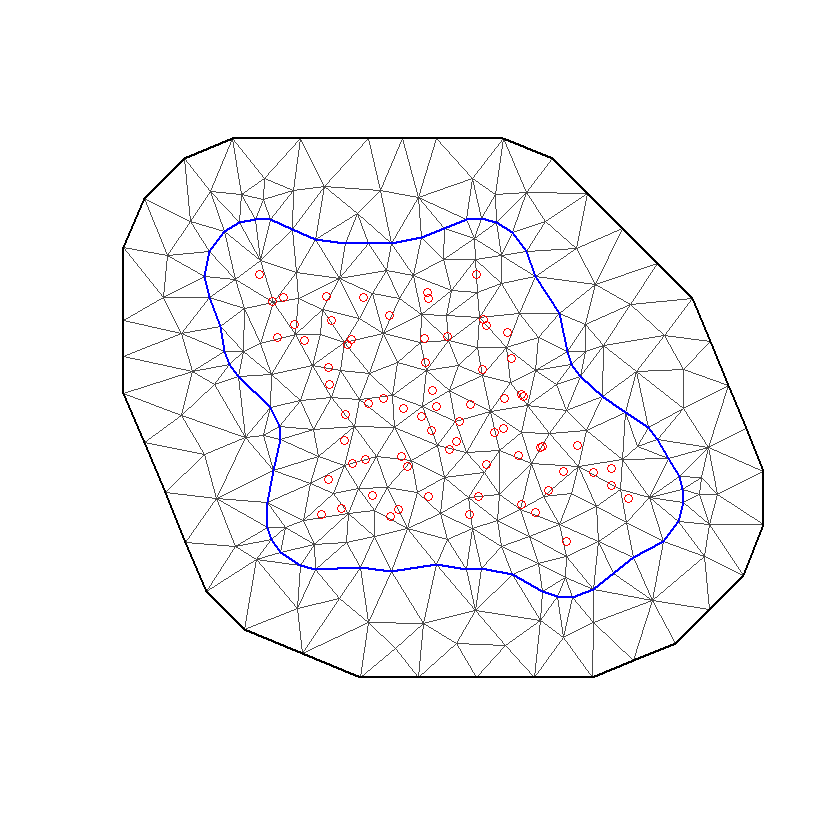

In [5]:
MOmesh <- inla.mesh.2d(boundary = boundary,
                       max.edge = c(0.8, 1.2), # max. edge length
                       cutoff = 0.1)           # min. edge length

plot(MOmesh,asp=1,main="");
lines(coords[c("lon","lat")],col="red",type="p")

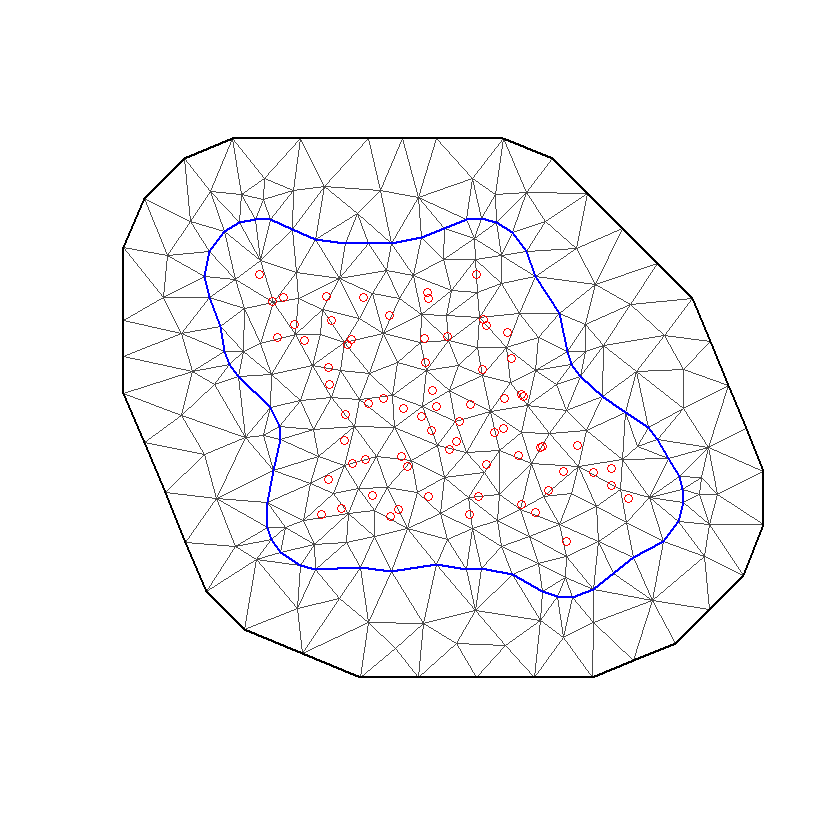

In [6]:
plot(MOmesh, asp = 1, main = "")
lines(coords[c("lon", "lat")], col = "red", type = "p")

In [7]:
spde <- inla.spde2.pcmatern(mesh = MOmesh,
                            alpha = 2,
                            prior.range = c(1, 0.01),
                            prior.sigma = c(4, 0.01))

In [8]:
n_years <- length(unique(MOcarolinawren_long$t))
n_spatial <- MOmesh$n
s_index <- inla.spde.make.index(name = "spatial.field",
                                n.spde = n_spatial,
                                n.group = n_years)

In [9]:
coords.allyear <- MOcarolinawren_long[c("lon", "lat")] %>%
                  as.matrix()
PHI <- inla.spde.make.A(mesh = MOmesh,
                        loc = coords.allyear,
                        group = MOcarolinawren_long$t,
                        n.group = n_years)

In [10]:
dim(PHI)

[1] 1575 5439

In [11]:
nrow(MOcarolinawren_long)
length(s_index$spatial.field)

[1] 1575

[1] 5439

In [12]:
n_data <- nrow(MOcarolinawren_long)
stack_est <- inla.stack(
                 data = list(cnt = MOcarolinawren_long$cnt),
                 A = list(PHI, 1),
                 effects = list(s_index,
                                list(Intercept = rep(1, n_data))),
                 tag = "est")


In [13]:
df_pred <- data.frame(lon = rep(MOmesh$loc[,1], n_years),
                      lat = rep(MOmesh$loc[,2], n_years),
                      t = rep(1:n_years, each = MOmesh$n))
n_pred <- nrow(df_pred)
PHI_pred <- Diagonal(n = n_pred)

In [14]:
stack_pred <- inla.stack(
                 data = list(cnt = NA),
                 A = list(PHI_pred, 1),
                 effects = list(s_index,
                                list(Intercept = rep(1, n_pred))),
                 tag = "pred")

In [15]:
stack <- inla.stack(stack_est, stack_pred)

In [16]:
rho_hyper <- list(theta=list(prior = 'pccor1',
                             param = c(0, 0.9)))

## Formula
formula <- cnt ~ -1 + Intercept +
                 f(spatial.field,
                   model = spde,
                   group = spatial.field.group,
                   control.group = list(model = "ar1",
                                        hyper = rho_hyper))

In [17]:
data("INLA_output", package = "STRbook")

,mean,sd,0.025quant,0.5quant,0.975quant,mode,kld
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,1.166,0.723,-0.384,1.197,2.546,1.249,0


,mean,sd,0.025quant,0.5quant,0.975quant,mode
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
size for the nbinomial observations (1/overdispersion),11.870,2.380,7.981,11.593,17.307,11.037
Range for spatial.field,2.514,0.525,1.650,2.457,3.702,2.345
Stdev for spatial.field,1.712,0.298,1.211,1.681,2.380,1.620
GroupRho for spatial.field,0.977,0.009,0.956,0.979,0.990,0.981


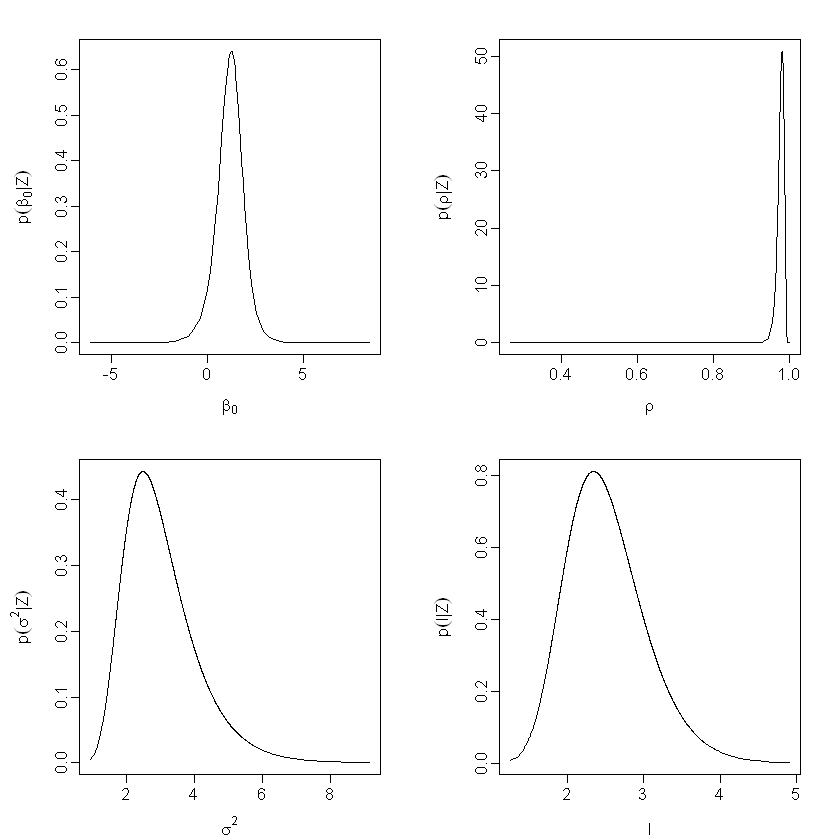

In [18]:
par(mgp=c(2.2,0.45,0), tcl=-0.4, mar=c(3.3,4,2,2))
par(mfrow=c(2,2))
output.field <- inla.spde2.result(inla = output,
                                  name = "spatial.field",
                                  spde = spde,
                                  do.transf = TRUE)
plot(output$marginals.fix[[1]],type ='l',xlab=expression(beta[0]),ylab=expression(p(beta[0]*"|"*Z)))
plot(output$marginals.hyperpar[[4]],type = 'l',xlab = expression(rho),ylab = expression(p(rho*"|"*Z)))
plot(output.field$marginals.variance.nominal[[1]],type = 'l',xlab = expression(sigma^2),ylab = expression(p(sigma^2*"|"*Z)))
plot(output.field$marginals.range.nominal[[1]],type = 'l',xlab = expression(l),ylab = expression(p(l*"|"*Z)))

## Inference results on beta, rho, variance, and range parameters
round(output$summary.fixed,3)
round(output$summary.hyperpar,3)

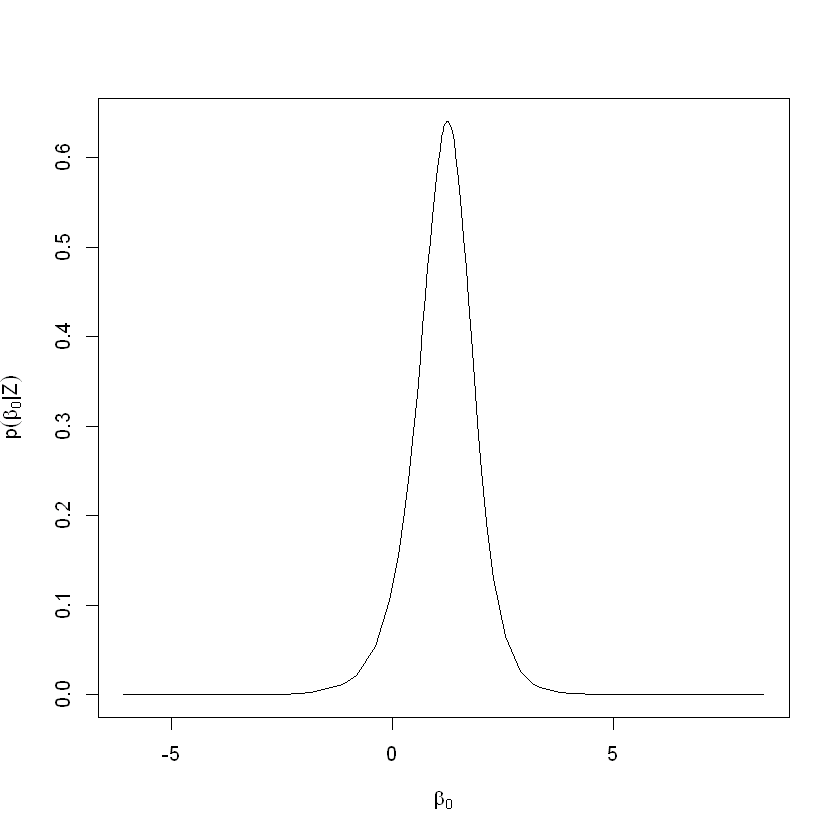

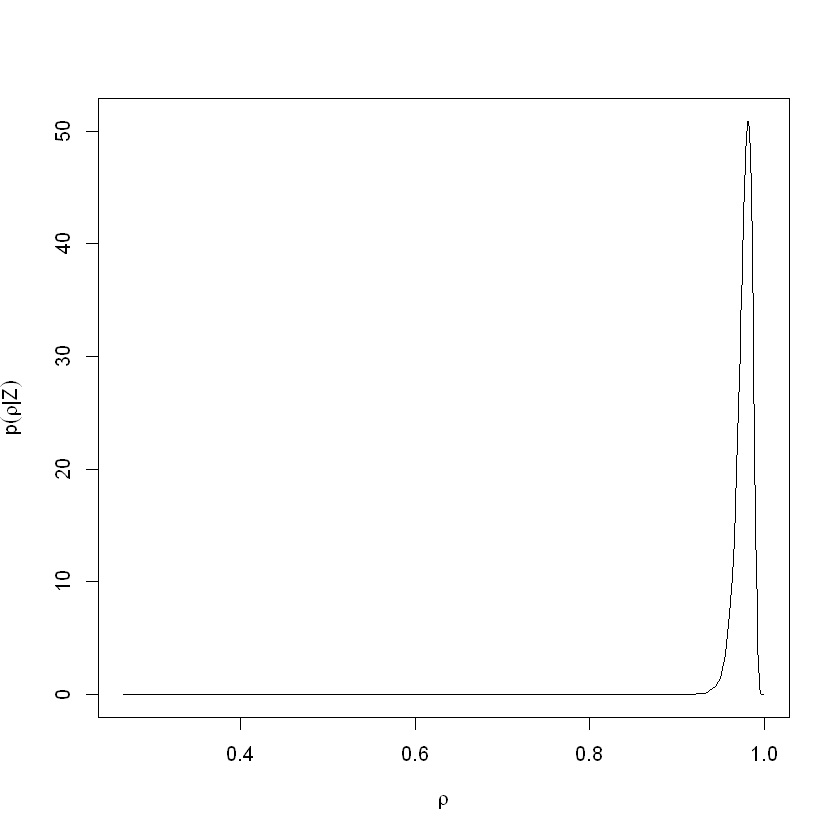

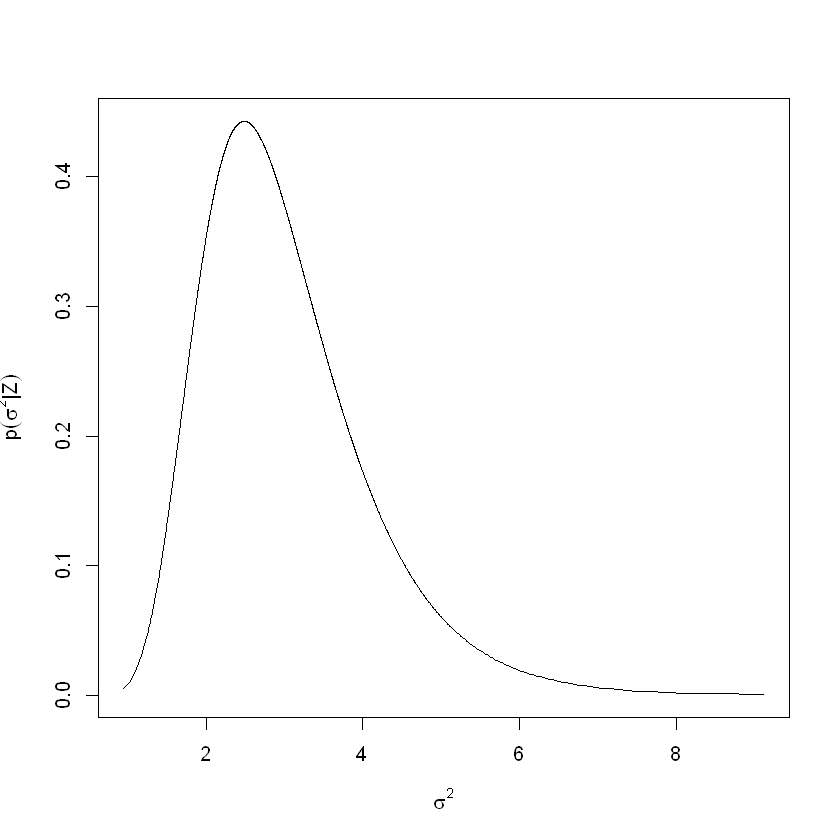

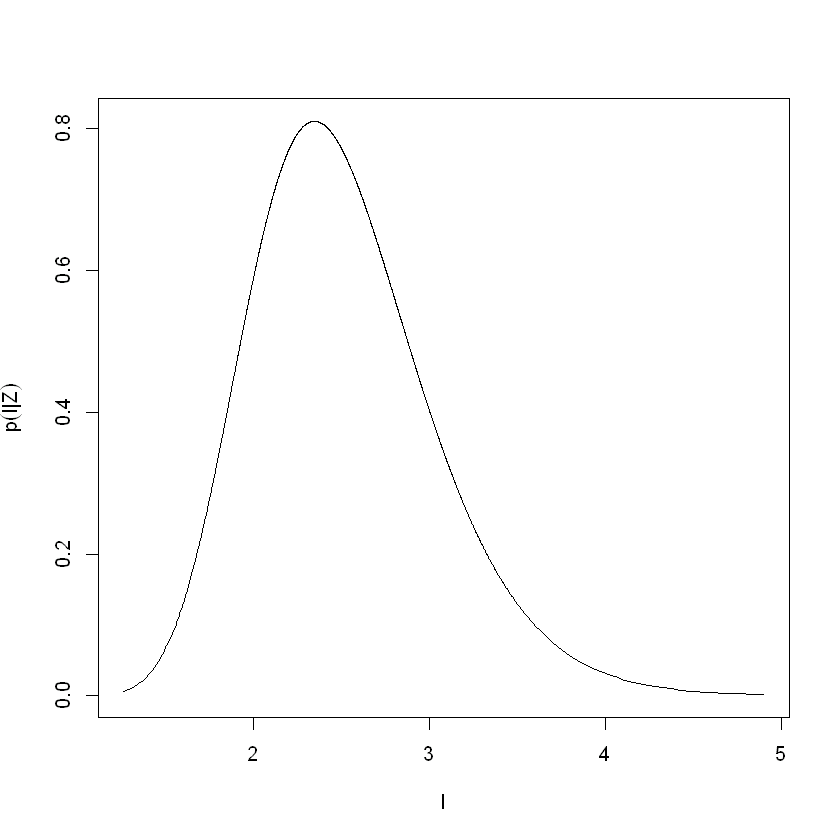

In [19]:
output.field <- inla.spde2.result(inla = output,
                                  name = "spatial.field",
                                  spde = spde,
                                  do.transf = TRUE)
## plot p(beta0 | Z)
plot(output$marginals.fix$Intercept,
     type = 'l',
     xlab = expression(beta[0]),
     ylab = expression(p(beta[0]*"|"*Z)))

## plot p(rho | Z)
plot(output$marginals.hyperpar$`GroupRho for spatial.field`,
     type = 'l',
     xlab = expression(rho),
     ylab = expression(p(rho*"|"*Z)))

## plot p(sigma^2 | Z)
plot(output.field$marginals.variance.nominal[[1]],
     type = 'l',
     xlab = expression(sigma^2),
     ylab = expression(p(sigma^2*"|"*Z)))

## plot p(range | Z)
plot(output.field$marginals.range.nominal[[1]],
     type = 'l',
     xlab = expression(l),
     ylab = expression(p(l*"|"*Z)))

In [20]:
index_pred <- inla.stack.index(stack, "pred")$data
lp_mean <- output$summary.fitted.values$mean[index_pred]
lp_sd <- output$summary.fitted.values$sd[index_pred]

In [21]:
grid_locs <- expand.grid(
                 lon = seq(min(MOcarolinawren_long$lon) - 0.2,
                           max(MOcarolinawren_long$lon) + 0.2,
                           length.out = 80),
                 lat = seq(min(MOcarolinawren_long$lat) - 0.2,
                           max(MOcarolinawren_long$lat) + 0.2,
                           length.out = 80))

In [22]:
proj.grid <- inla.mesh.projector(MOmesh,
                    xlim = c(min(MOcarolinawren_long$lon) - 0.2,
                             max(MOcarolinawren_long$lon) + 0.2),
                    ylim = c(min(MOcarolinawren_long$lat) - 0.2,
                             max(MOcarolinawren_long$lat) + 0.2),
                    dims = c(80, 80))

In [23]:
pred <- sd <-  NULL
for(i in 1:n_years) {
    ii <- (i-1)*MOmesh$n + 1
    jj <- i*MOmesh$n
    pred[[i]] <- cbind(grid_locs,
                       z = c(inla.mesh.project(proj.grid,
                                             lp_mean[ii:jj])),
                       t = i)
    sd[[i]] <- cbind(grid_locs,
                     z = c(inla.mesh.project(proj.grid,
                                             lp_sd[ii:jj])),
                     t = i)
}

In [24]:
pred <- do.call("rbind", pred) %>% filter(!is.na(z))
sd <- do.call("rbind", sd) %>% filter(!is.na(z))

In [25]:
df_tot <- group_by(MOcarolinawren_long,lon,lat) %>%
          dplyr::summarise(tot_cnt = sum(cnt,na.rm=T))

g1 <- ggplot() + geom_raster(data=pred,aes(lon,lat,fill=pmin(z,5))) + facet_wrap(~t,nrow=3,ncol=7) +
    geom_point(data=filter(MOcarolinawren_long,!is.na(cnt)),aes(lon,lat),colour="black",size=3) +
    geom_point(data=filter(MOcarolinawren_long,!is.na(cnt)),aes(lon,lat,colour=log(cnt)),size=2) +
    scale_colour_distiller(palette="Spectral",limits=c(-1,5)) +
    scale_fill_distiller(palette="Spectral",limits=c(-1,5),name=expression(log(Y[t]))) + theme_bw()

g2 <- ggplot() + geom_raster(data=sd,aes(lon,lat,fill=z)) + facet_wrap(~t,nrow=3,ncol=7) +
    scale_fill_distiller(palette="BrBG",limits=c(0,2.5),name=expression(s.e.)) + theme_bw()

`summarise()` has grouped output by 'lon'. You can override using the `.groups`
argument.


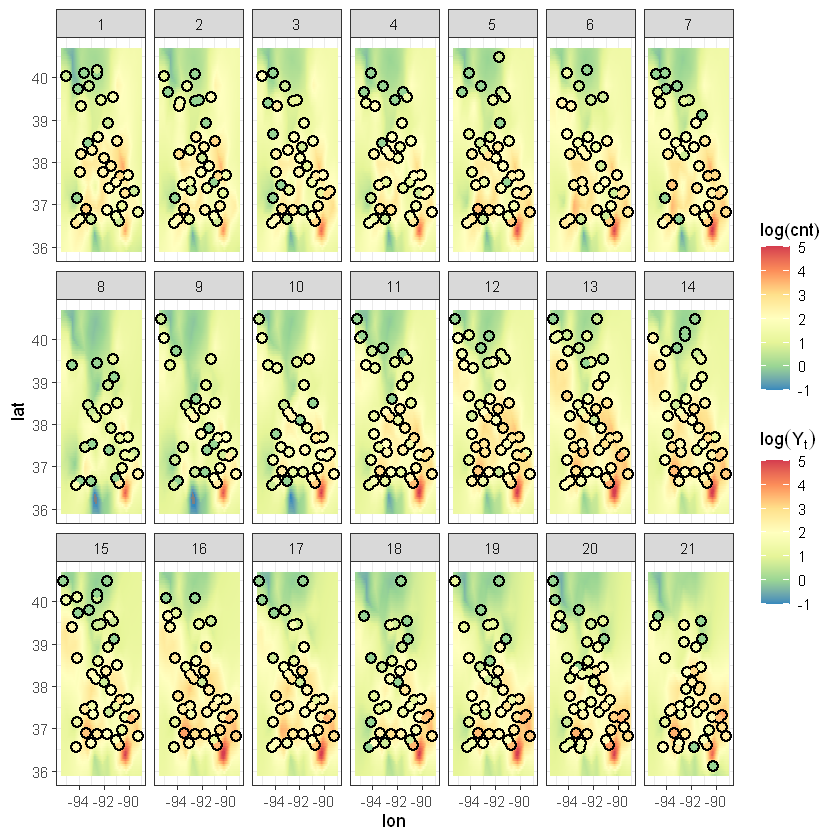

In [26]:
g1

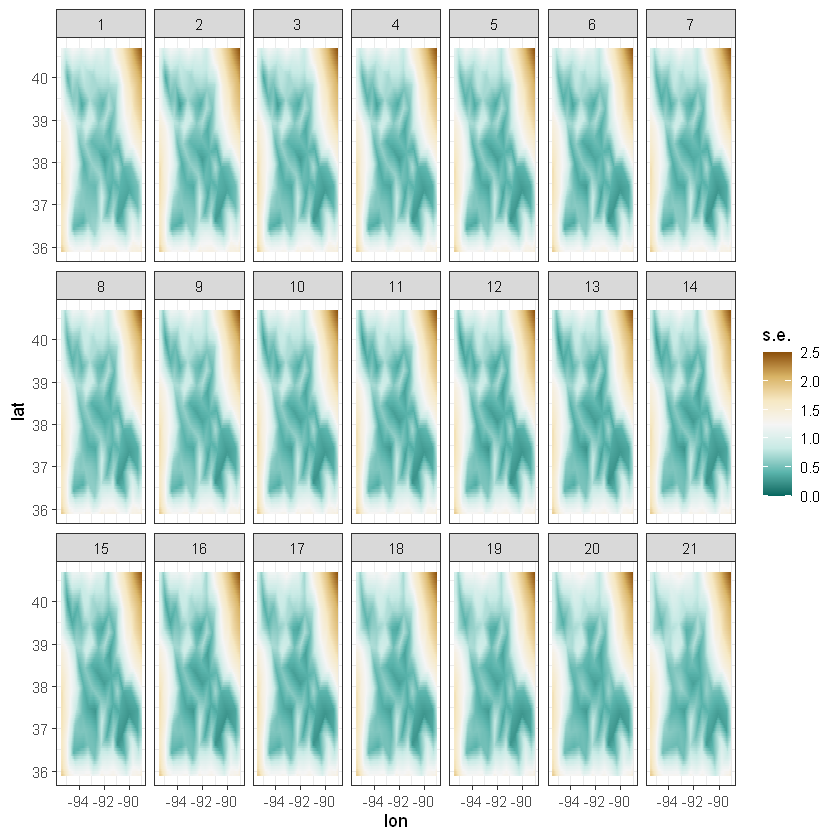

In [27]:
g2